<img src="PEST++V3_cover.jpeg" style="float: left">

<img src="flopylogo.png" style="float: right">

<img src="AW&H2015.png" style="float: center">

# History match the Freyberg model using a two parameters ``K`` and ``R`` using head and flux observations

#### Where are we on the Goldilocks complexity curve? 

<img src="Hunt1998_sweetspot.png" style="float: center">



The runs so far were intended to be greatly oversimplified so as to be a starting point for adding complexity. However, when we added just __*one more parameter*__ for a total of 2 parameters uncerainty for some forecasts got appreciably __worse__.  And these parameters cover the entire model domain, which is unrealistic for the natural world!  Are we past the "sweetspot" and should avoid any additional complexity even if our model looks nothing like reality?  

Adding parameters in and of itself is not the real problem.  Rather, it is adding parameters that influence forecasts but are unconstrained by observations so that they are free to wiggle and ripple uncertainty to our forcasts.  If observations are added that help constrain the parameters, the forecast observation will be more certain. That is, the natural flip side of adding parameters is constraining them, with data (first line of defense) or soft-knowledge and problem dimension reduciton (SVD).  

Anderson et al. (2015) suggest that at a minimum groundwater models be history matched to heads and fluxes.  There is a flux observation in our PEST control file, but it was given zero weight.  Let's see what happens if we move our model to the minimum calibration of Anderson et al.

#### Objectives for this notebook are to:

1) Add a flux observation to the measurement objective function of our Freyberg model

2) Explore the effect of adding the observation to history matching, parameter uncertainty, and forecast uncertainty

In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import pyemu

In [2]:
import freyberg_setup as fs
pst_name = fs.PST_NAME_KR
working_dir = fs.WORKING_DIR_KR
fs.setup_pest_kr()
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = 0
pst.observation_data.loc[pst.observation_data.obgnme=='calflux', 'weight']=0
pst.write(os.path.join(working_dir,pst_name))

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...

changing model workspace...
   freyberg_kr
FloPy is using the following executable to run the model: /Users/rjhunt1/GW1876-SD18/activities/freyberg_k_and_r_fluxobs/freyberg_kr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.1, 7/21/2016                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 07/21/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/04/22 10:42:46

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1  

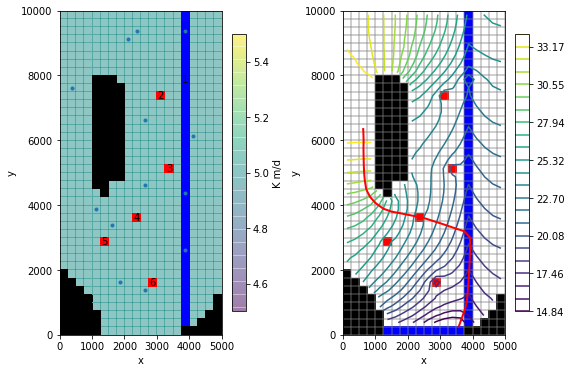

In [4]:
# plot K field and simulated heads and particle tracking
fs.plot_model(working_dir, pst_name)

#### Let's break out the pyemu command to run the forward model
Watch the terminal window to see the run progress....

In [5]:
# run PEST++ 
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

``PEST++`` only ran the model one time - because NOPTMAX=0, but that is what we want at this point to interrogate the model at initial values.  

### Let's look at all observations in the PEST run

In [8]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
# echo the observation data
pst.observation_data

,obsnme,obsval,weight,obgnme,extra
obsnme,,,,,
c001cr03c10_19700102,c001cr03c10_19700102,2.666153e+01,5.0,calhead,NaN
c001cr03c16_19700102,c001cr03c16_19700102,2.346056e+01,5.0,calhead,NaN
c001cr04c09_19700102,c001cr04c09_19700102,2.851352e+01,5.0,calhead,NaN
c001cr10c02_19700102,c001cr10c02_19700102,3.074169e+01,5.0,calhead,NaN
c001cr14c11_19700102,c001cr14c11_19700102,2.587121e+01,5.0,calhead,NaN
c001cr16c17_19700102,c001cr16c17_19700102,1.981724e+01,5.0,calhead,NaN
c001cr22c11_19700102,c001cr22c11_19700102,2.485856e+01,5.0,calhead,NaN
c001cr23c16_19700102,c001cr23c16_19700102,1.950900e+01,5.0,calhead,NaN
c001cr25c05_19700102,c001cr25c05_19700102,2.525171e+01,5.0,calhead,NaN


Wow!  that's a lot of observations.  Why so many?  Answer:  we are "carrying" lots of model outputs that may be of interest to us later __(not just places and times where we have actual measurements)__.  These outputs include forecasts as well as *"potential" observation* locations we will use in dataworth analysis (more on that later)

But, the calibration only uses observations where you assign weights.  Let's get a listing of just those.

In [9]:
# filter the output based on non-zero weights
pst.observation_data.loc[pst.nnz_obs_names,:]

,obsnme,obsval,weight,obgnme,extra
obsnme,,,,,
c001cr03c10_19700102,c001cr03c10_19700102,26.661526,5.0,calhead,NaN
c001cr03c16_19700102,c001cr03c16_19700102,23.460564,5.0,calhead,NaN
c001cr04c09_19700102,c001cr04c09_19700102,28.513522,5.0,calhead,NaN
c001cr10c02_19700102,c001cr10c02_19700102,30.741689,5.0,calhead,NaN
c001cr14c11_19700102,c001cr14c11_19700102,25.871208,5.0,calhead,NaN
c001cr16c17_19700102,c001cr16c17_19700102,19.817240,5.0,calhead,NaN
c001cr22c11_19700102,c001cr22c11_19700102,24.858561,5.0,calhead,NaN
c001cr23c16_19700102,c001cr23c16_19700102,19.509003,5.0,calhead,NaN
c001cr25c05_19700102,c001cr25c05_19700102,25.251713,5.0,calhead,NaN


#### Here we have only head calibration targets (calhead).  But it is recommended that we calibrate to heads and fluxes.  

Let's give the observation ``rivflux_cal`` a non-zero weight.  You can do this in a text editor but we'll do it in the next block and see the report out for convenience. We chose a new weight of 0.05 for this problem, but we'll spend more time on the concepts involved with observation weighting in a later notebook.

In [10]:
obs = pst.observation_data
obs.loc[obs.obgnme=="calflux","weight"] = 0.05 #super subjective
pst.observation_data.loc[pst.nnz_obs_names,:]

,obsnme,obsval,weight,obgnme,extra
obsnme,,,,,
c001cr03c10_19700102,c001cr03c10_19700102,26.661526,5.00,calhead,NaN
c001cr03c16_19700102,c001cr03c16_19700102,23.460564,5.00,calhead,NaN
c001cr04c09_19700102,c001cr04c09_19700102,28.513522,5.00,calhead,NaN
c001cr10c02_19700102,c001cr10c02_19700102,30.741689,5.00,calhead,NaN
c001cr14c11_19700102,c001cr14c11_19700102,25.871208,5.00,calhead,NaN
c001cr16c17_19700102,c001cr16c17_19700102,19.817240,5.00,calhead,NaN
c001cr22c11_19700102,c001cr22c11_19700102,24.858561,5.00,calhead,NaN
c001cr23c16_19700102,c001cr23c16_19700102,19.509003,5.00,calhead,NaN
c001cr25c05_19700102,c001cr25c05_19700102,25.251713,5.00,calhead,NaN


Note that now we see calflux as an observation target, and it has our new (non-zero) weight....

### Now let's change NOPTMAX from 0 to 20 so we can see what the effect of weighting the flux target is

In [12]:
pst.control_data.noptmax = 20
# now write what pyemu has in its memory to disk so we can run it
pst.write(os.path.join(working_dir,pst_name))

#### And we'll run the model - look at the terminal window where you launched this notebook to see the progress of PEST++.  Advance through the code blocks when you see a 0 returned.

In [13]:
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

#### Let's explore the results, how did we do with fit (lowering PHI)?

In [15]:
df_obj = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".iobj")),index_col=0)
df_obj

,model_runs_completed,total_phi,measurement_phi,regularization_phi,calflux,calhead,flaqx,flout,flx_constan,flx_in-out,...,forecast,pothead,vol_constan,vol_in-out,vol_percent,vol_recharg,vol_storage,vol_stream_,vol_total,vol_wells
iteration,,,,,,,,,,,,,,,,,,,,,
0,0,1317.04,1317.04,0,80.192,1236.850,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,1059.04,1059.04,0,195.021,864.017,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11,1058.97,1058.97,0,191.407,867.566,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,18,1059.03,1059.03,0,192.516,866.517,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Egads!  Our Phi is a bit larger!  Are we moving backwards? Oh wait, we added a new weighted observation, so we can't compare it directly to what we had with only head observations.


#### Okay, what did it do to our parameter uncertainty?

In [16]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
HK,0.69897,0.500000,-0.30103,1.69897,0.783506,0.049866,0.683774,0.883238
POROSITY,-2.00000,0.150515,-2.30103,-1.69897,-2.000000,0.150515,-2.301030,-1.698970


# Hold the phone - only K is showing here.  Did we run PESTCHEK before burning the silicon? 

 (Remember last notebook where we said:  "Let's run PESTCHEK and see what it says about our freyberg.pst file"?)


In [17]:
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)

#### Check your terminal to see the PESTCHEK results.

Well the instructors gave you the same PEST control file as last exerisce!  Some one should tell them that it was "curious" in the last notebook but vexxing now, because we again see that in the PESTCHEK warning section it says "All parameters belonging to the parameter group "rch" are either fixed or tied". That is flagged as a warning because PESTCHEK is wondering (with good reason in this case) why would it not be adjustable after you went to all the trouble to define it as a parameter.  But, there  are times you may want to do this, so it is classified as a warning and isn't going to stop you.

#### But that is not what we want, we want to make recharge a parameter in this activity and redo our work (did we remember to mention the importance of running PESTCHEK?)

### Open the PEST control file freyberg.pst in your text editor.  

1) Look in the parameter data section

2) Find the parameter __rch_0__ (the recharge for the calibration period) and make it adjustable (hint:  look at the other parameters) 

3) Save the file

4) Run PESTCHEK on the PEST control file in a seperate terminal window or by executing the next code block and looking at the terminal window where you launched this notebook

## Or run this next pyemu block

In [18]:
pst.parameter_data.loc["rch_0",'partrans'] = "log"
pst.write(os.path.join(working_dir,pst_name))

In [19]:
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)

### Now to redo our steps from above....look at the terminal window where you launched this notebook to see the progress of PEST++.  Advance through the code blocks when you see a 0 returned.

In [20]:
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

### Again, let's look at results

In [21]:
df_obj = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".iobj")),index_col=0)
df_obj

,model_runs_completed,total_phi,measurement_phi,regularization_phi,calflux,calhead,flaqx,flout,flx_constan,flx_in-out,...,forecast,pothead,vol_constan,vol_in-out,vol_percent,vol_recharg,vol_storage,vol_stream_,vol_total,vol_wells
iteration,,,,,,,,,,,,,,,,,,,,,
0,0,1317.040,1317.040,0,80.1920,1236.850,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,821.882,821.882,0,0.0049,821.877,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13,818.264,818.264,0,0.0441,818.220,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22,818.236,818.236,0,0.1296,818.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


An aside: not much improvement in phi from the run where recharge was fixed...why would that be? But at least it is better! 

#### Let's look at the parameter uncertainty

In [26]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
HK,0.69897,0.500000,-0.30103,1.69897,0.860686,0.061805,0.737076,0.984297
POROSITY,-2.00000,0.150515,-2.30103,-1.69897,-2.000000,0.150515,-2.301030,-1.698970
RCH_0,0.00000,0.150515,-0.30103,0.30103,0.031161,0.007366,0.016429,0.045893


### Much better to have recharge in there - thanks PESTCHEK.  Yes, RCH_0 has a mean of zero but remember we log transformed it and it is reported in log space.  

### Now let's compare the parameter uncertainty results with the flux observation above to the previous run where we zero weighted the flux observation below:

In [28]:
# make a dataframe from the old run that had K and R but head-only calibration
df_paru_base = pd.read_csv(os.path.join("..","freyberg_k_and_r",
                                        working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
# echo out the dataframe
df_paru_base

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
HK,0.69897,0.500000,-0.30103,1.69897,0.923862,0.159991,0.603880,1.243840
POROSITY,-2.00000,0.150515,-2.30103,-1.69897,-2.000000,0.150515,-2.301030,-1.698970
RCH_0,0.00000,0.150515,-0.30103,0.30103,0.087894,0.126451,-0.165008,0.340796



###  Uncertainty in the gw flow parameters is lower when we add an observation that can constrain the parameters.  

### Here's the parameter uncertainty for the K and R parameters, side by side, heads+flux observation vs heads only

In [29]:
df_paru_concat = pd.concat([df_paru,df_paru_base],join="outer",axis=1,keys=["heads+fluxobs","heads_only"])
df_paru_concat

heads+fluxobs                                                  \
            prior_mean prior_stdev prior_lower_bound prior_upper_bound   
name                                                                     
HK             0.69897    0.500000          -0.30103           1.69897   
POROSITY      -2.00000    0.150515          -2.30103          -1.69897   
RCH_0          0.00000    0.150515          -0.30103           0.30103   

                                                                heads_only  \
         post_mean post_stdev post_lower_bound post_upper_bound prior_mean   
name                                                                         
HK        0.860686   0.061805         0.737076         0.984297    0.69897   
POROSITY -2.000000   0.150515        -2.301030        -1.698970   -2.00000   
RCH_0     0.031161   0.007366         0.016429         0.045893    0.00000   

                                                                               \
         prior_stdev prior_lower_bound prior_upper_bound post_mean post_stdev   
name                                                                            
HK          0.500000          -0.30103           1.69897  0.923862   0.159991   
POROSITY    0.150515          -2.30103          -1.69897 -2.000000   0.150515   
RCH_0       0.150515          -0.30103           0.30103  0.087894   0.126451   

                                            
         post_lower_bound post_upper_bound  
name                                        
HK               0.603880         1.243840  
POROSITY        -2.301030        -1.698970  
RCH_0           -0.165008         0.340796

Interesting - a tradeoff with fit between the two types of observations...


###  Let's plot these up like before.  Here's the prior and posterior standard deviations (blue is with flux observation weighted, green is with zero weight on the flux target)


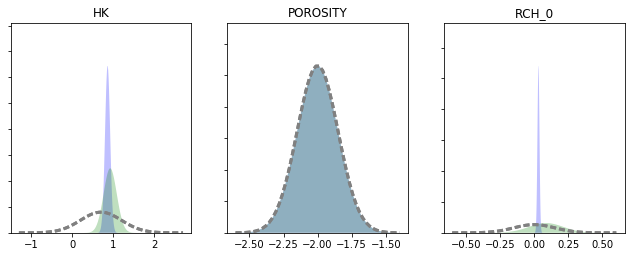

In [30]:
figs,axes = pyemu.helpers.plot_summary_distributions(df_paru,subplots=True)
for pname,ax in zip(pst.adj_par_names,axes):
    pyemu.helpers.plot_summary_distributions(df_paru_base.loc[[pname.upper()],:],ax=ax,pt_color="g")

##  Wow, from an uncertainty standpoint, the flux observation has helped us learn a lot about recharge, and the reduction in that uncertainty in turn reduced the uncertainty in HK (blue posterior is narrower and higher than green)

# Let's look at our forecasts - here's the K and R model with the flux observation with weight:

In [31]:
df_foreu = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".pred.usum.csv")),index_col=0)
df_foreu.loc[:,"reduction"] = 100.0 *  (1.0 - (df_foreu.post_stdev / df_foreu.prior_stdev))

df_foreu

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound,reduction
name,,,,,,,,,
C001FR05C04_19791231,33.1496,7.77583,17.5980,48.7013,30.9005,0.840034,29.2204,32.5805,89.196857
C001FR16C17_19791231,21.8734,0.38866,21.0961,22.6508,21.7697,0.038428,21.6929,21.8466,90.112669
FA_HEADWATERS_0001,-737.5590,698.85500,-2135.2700,660.1520,-677.9650,46.285300,-770.5360,-585.3950,93.376981
TRAVEL_TIME,14750.2000,11214.50000,-7678.7400,37179.1000,10527.2000,3915.910000,2695.3800,18359.0000,65.081725


### Compare these results with the ``k_and_r`` model *without* the flux observation (below):

In [32]:
df_foreu_base = pd.read_csv(os.path.join("..","freyberg_k_and_r",
                                         working_dir,pst_name.replace(".pst",".pred.usum.csv")),index_col=0)
df_foreu_base.loc[:,"reduction"] = 100.0 *  (1.0 - (df_foreu_base.post_stdev / df_foreu_base.prior_stdev))
df_foreu_base

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound,reduction
name,,,,,,,,,
C001FR05C04_19791231,33.1496,7.067750,19.0141,47.2851,30.6519,1.077920,28.4961,32.8077,84.748753
C001FR16C17_19791231,21.8734,0.391052,21.0913,22.6555,21.7755,0.054651,21.6662,21.8848,86.024672
FA_HEADWATERS_0001,-737.5590,1302.710000,-3342.9800,1867.8600,-781.0830,228.533000,-1238.1500,-324.0170,82.457109
TRAVEL_TIME,14750.2000,5475.900000,3798.3800,25702.0000,9059.6900,2316.950000,4425.7800,13693.6000,57.688234


### And here the forecast uncertianties are side by side

In [36]:
df_foreu_concat = pd.concat([df_foreu,df_foreu_base],join="outer",axis=1,keys=["heads+fluxobs","heads_only"])
df_foreu_concat

heads+fluxobs                                 \
                        prior_mean  prior_stdev prior_lower_bound   
name                                                                
C001FR05C04_19791231       33.1496      7.77583           17.5980   
C001FR16C17_19791231       21.8734      0.38866           21.0961   
FA_HEADWATERS_0001       -737.5590    698.85500        -2135.2700   
TRAVEL_TIME             14750.2000  11214.50000        -7678.7400   

                                                                 \
                     prior_upper_bound   post_mean   post_stdev   
name                                                              
C001FR05C04_19791231           48.7013     30.9005     0.840034   
C001FR16C17_19791231           22.6508     21.7697     0.038428   
FA_HEADWATERS_0001            660.1520   -677.9650    46.285300   
TRAVEL_TIME                 37179.1000  10527.2000  3915.910000   

                                                                   heads_only  \
                     post_lower_bound post_upper_bound  reduction  prior_mean   
name                                                                            
C001FR05C04_19791231          29.2204          32.5805  89.196857     33.1496   
C001FR16C17_19791231          21.6929          21.8466  90.112669     21.8734   
FA_HEADWATERS_0001          -770.5360        -585.3950  93.376981   -737.5590   
TRAVEL_TIME                 2695.3800       18359.0000  65.081725  14750.2000   

                                                                       \
                      prior_stdev prior_lower_bound prior_upper_bound   
name                                                                    
C001FR05C04_19791231     7.067750           19.0141           47.2851   
C001FR16C17_19791231     0.391052           21.0913           22.6555   
FA_HEADWATERS_0001    1302.710000        -3342.9800         1867.8600   
TRAVEL_TIME           5475.900000         3798.3800        25702.0000   

                                                               \
                      post_mean   post_stdev post_lower_bound   
name                                                            
C001FR05C04_19791231    30.6519     1.077920          28.4961   
C001FR16C17_19791231    21.7755     0.054651          21.6662   
FA_HEADWATERS_0001    -781.0830   228.533000       -1238.1500   
TRAVEL_TIME           9059.6900  2316.950000        4425.7800   

                                                  
                     post_upper_bound  reduction  
name                                              
C001FR05C04_19791231          32.8077  84.748753  
C001FR16C17_19791231          21.8848  86.024672  
FA_HEADWATERS_0001          -324.0170  82.457109  
TRAVEL_TIME                13693.6000  57.688234

### and plotted ( (blue is with flux observation weighted, green is with zero weight on the flux target)

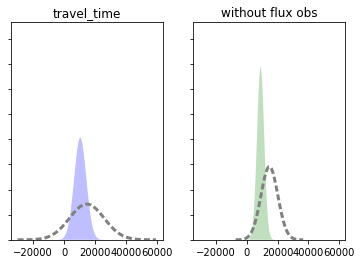

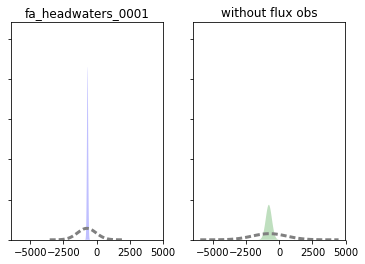

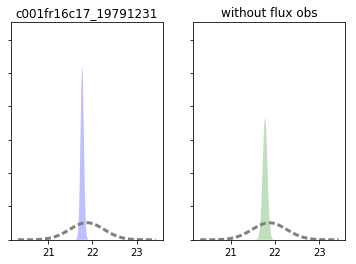

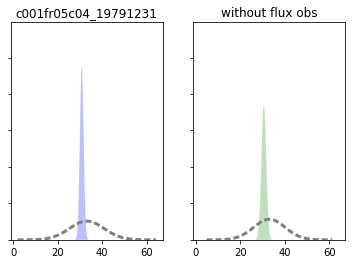

In [34]:
for forecast in pst.forecast_names:
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    pyemu.helpers.plot_summary_distributions(df_foreu.loc[[forecast.upper()],:],ax=ax1)
    pyemu.helpers.plot_summary_distributions(df_foreu_base.loc[[forecast.upper()],:],
                                             ax=ax2,pt_color='g')
    xlim1, xlim2 = ax1.get_xlim(),ax2.get_xlim()
    xmx = max(xlim1[1],xlim2[1])
    xmn = min(xlim1[0],xlim2[0])
    ax1.set_xlim(xmn,xmx)
    ax2.set_xlim(xmn,xmx)
    ylim1, ylim2 = ax1.get_ylim(),ax2.get_ylim()  
    ymx = max(ylim1[1],ylim2[1])
    ymn = min(ylim1[0],ylim2[0])
    ax1.set_ylim(ymn,ymx)
    ax2.set_ylim(ymn,ymx)
    
    
    ax1.set_title(forecast)
    ax2.set_title("without flux obs")
    plt.show()

## Let's compare the standard deviations for the forecasts

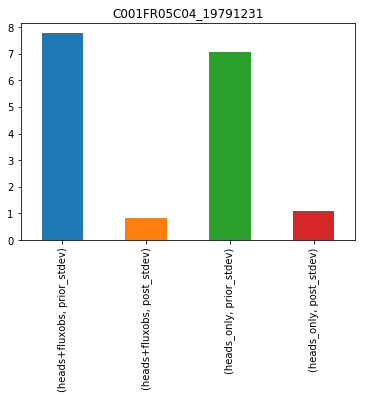

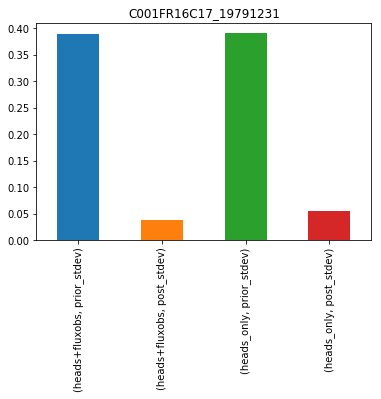

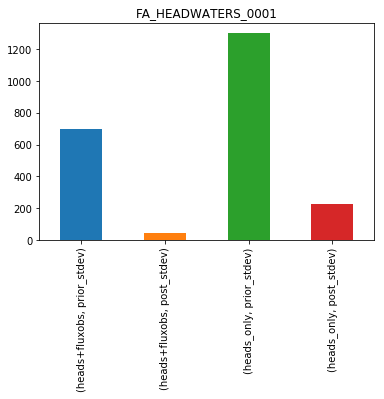

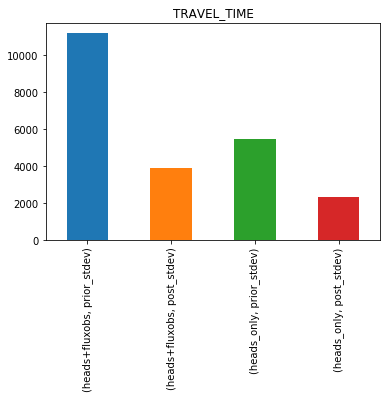

In [35]:
for forecast in df_foreu_concat.index:
    df_foreu_concat.loc[forecast,(slice(None),("prior_stdev","post_stdev"))].plot(kind="bar",subplots=True)
    plt.show()

# Advanced digression - what's wrong with FOSM...
### Why are the Prior distributions for the flux obs and no flux obs forecasts different? - I thought Priors should be the same between these two?

### Let's look at wat is reported in the Jacobian for these parameters

In [39]:
# pull the Jacobian from this run and call it jco
jco = pyemu.Jco.from_binary(os.path.join(working_dir,pst_name.replace(".pst",".jcb")))
# make a dataframe from this Jacobian
df = jco.to_dataframe()
# for the observation "travel time" list the sensitivity that is in the Jacobian
df.loc["travel_time",:]

hk         -21172.841309
porosity    24482.152751
rch_0       -2234.151547
Name: travel_time, dtype: float64

In [41]:
# pull the Jacobian from the previous heads-only calibration from our K and R run and call it jco
jco = pyemu.Jco.from_binary(os.path.join("..","freyberg_k_and_r",working_dir,pst_name.replace(".pst",".jcb")))
# make a dataframe from this Jacobian
df2 = jco.to_dataframe()
# for the observation "travel time" list the sensitivity that is in the Jacobian
df2.loc["travel_time",:]

hk         -10500.193130
porosity    10334.901697
rch_0        -312.200598
Name: travel_time, dtype: float64

### well the parameter sensitivity is different at these different optimal values....and the linear uncertainty asumption of FOSM doesn't consider that there may be different sensitvities 

The information in the flux obs has reduced river flux forecast uncertainty dramatically, but has not really improved what we had before with respect to the ``travel_time`` or head forecasts.  So on first blush we see that the same model/observation data set can make some forecasts better but not others

### But there is more to it than that - think about which observation helped which parameter and which forecast the most.  Is there an "birds of the feather" type of thing going on?  


# Okay, we took you a long way but doesn't our approach to uncertainty have a huge flaw?  We freed recharge rch_0 which is the calibration period that we know something about.  But we left the recharge in the forecast period (rch_1) fixed - which is saying that we know it perfectly, which makes no sense.  This set of blocks will recreate the steps above and get us back to the parameter and forecast uncertainty plots....

In [42]:
pst.parameter_data.loc[["rch_0","rch_1"],"partrans"] = "log"
pst.write(os.path.join(working_dir,pst_name))
pst.parameter_data



,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk,hk,log,factor,5.00,0.500,50.00,hk,1.0,0.0,1,NaN
porosity,porosity,log,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN
rch_0,rch_0,log,factor,1.00,0.500,2.00,rch,1.0,0.0,1,NaN
rch_1,rch_1,log,factor,1.00,0.250,3.00,rch,1.0,0.0,1,NaN


In [46]:
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)
# check the terminal to see the pestchek output

In [47]:
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

In [45]:
df_obj = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".iobj")),index_col=0)
df_obj

,model_runs_completed,total_phi,measurement_phi,regularization_phi,calflux,calhead,flaqx,flout,flx_constan,flx_in-out,...,forecast,pothead,vol_constan,vol_in-out,vol_percent,vol_recharg,vol_storage,vol_stream_,vol_total,vol_wells
iteration,,,,,,,,,,,,,,,,,,,,,
0,0,1317.040,1317.040,0,80.1920,1236.850,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,821.882,821.882,0,0.0049,821.877,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,818.264,818.264,0,0.0441,818.220,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,26,818.236,818.236,0,0.1296,818.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df_paru_f = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru_f

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
HK,0.69897,0.500000,-0.301030,1.698970,0.860686,0.061805,0.737076,0.984297
POROSITY,-2.00000,0.150515,-2.301030,-1.698970,-2.000000,0.150515,-2.301030,-1.698970
RCH_0,0.00000,0.150515,-0.301030,0.301030,0.031161,0.007366,0.016429,0.045893
RCH_1,0.00000,0.269795,-0.539591,0.539591,0.000000,0.269795,-0.539591,0.539591


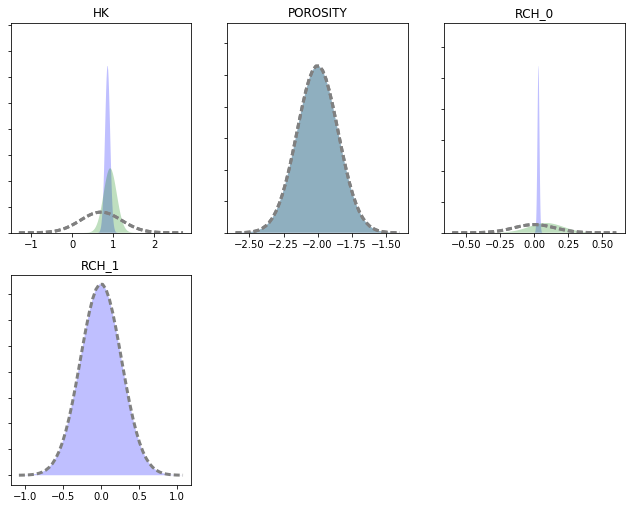

In [52]:
figs,axes = pyemu.helpers.plot_summary_distributions(df_paru_f,subplots=True)
for pname,ax in zip(pst.adj_par_names,axes):
    if pname.upper() == "RCH_1":
        continue
    pyemu.helpers.plot_summary_distributions(df_paru_base.loc[[pname.upper()],:],ax=ax,pt_color="g")

# Ah, for the future recharge there is no change between the prior and posterior uncertainty, but this makes sense because there are no weighted observations (information) regarding the future. So our calibration data tells us nothing about the this parameter.  

## How does this new source of uncertainty ripple to our forecast uncertainty?

# Jeremy - can you fix this so it plots the rch_1 fixed vs freed change in FOSM?

In [53]:
df_foreu_f = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".pred.usum.csv")),index_col=0)
df_foreu_f

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
C001FR05C04_19791231,33.1496,7.842540,17.4645,48.8347,30.9005,1.321960,28.2565,33.5444
C001FR16C17_19791231,21.8734,0.490744,20.8919,22.8549,21.7697,0.302075,21.1656,22.3739
FA_HEADWATERS_0001,-737.5590,957.137000,-2651.8300,1176.7200,-677.9650,655.634000,-1989.2300,633.3020
TRAVEL_TIME,14750.2000,11244.500000,-7738.7700,37239.1000,10527.2000,4001.060000,2525.0700,18529.3000


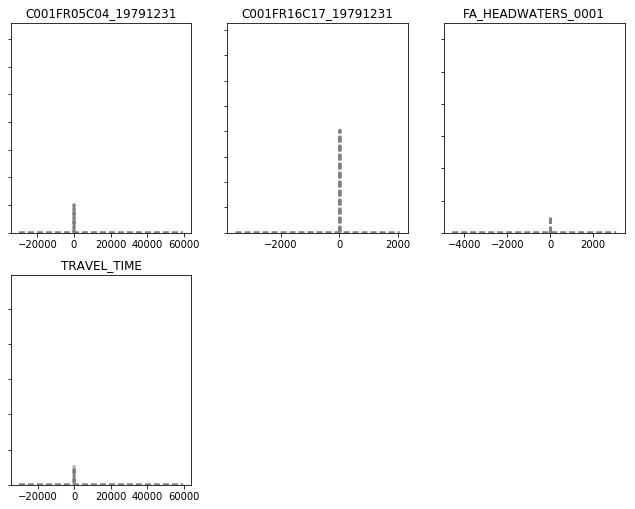

In [54]:
figs,axes = pyemu.helpers.plot_summary_distributions(df_foreu_f,subplots=True)
for forecast,ax in zip(pst.forecast_names,axes):
    pyemu.helpers.plot_summary_distributions(df_foreu.loc[[forecast.upper()],:],ax=ax,pt_color="g")

In [55]:
jco = pyemu.Jco.from_binary(os.path.join(working_dir,pst_name.replace(".pst",".jcb")))
df = jco.to_dataframe()

In [56]:
df.loc[pst.forecast_names,:]

,hk,porosity,rch_0,rch_1
travel_time,-21172.841309,2.448215e+04,-2234.151547,-3043.287886
fa_headwaters_0001,1092.571180,8.742051e-12,-2895.766009,-2424.052771
c001fr16c17_19791231,-0.728620,-3.328353e-13,0.899621,1.110550
c001fr05c04_19791231,-15.084556,-7.477601e-13,12.566521,3.783386


In [57]:
df_foreu_concat = pd.concat([df_foreu,df_foreu_f],join="outer",axis=1,keys=["base","rch_1"])
df_foreu_concat

base                                 \
                      prior_mean  prior_stdev prior_lower_bound   
name                                                              
C001FR05C04_19791231     33.1496      7.77583           17.5980   
C001FR16C17_19791231     21.8734      0.38866           21.0961   
FA_HEADWATERS_0001     -737.5590    698.85500        -2135.2700   
TRAVEL_TIME           14750.2000  11214.50000        -7678.7400   

                                                                 \
                     prior_upper_bound   post_mean   post_stdev   
name                                                              
C001FR05C04_19791231           48.7013     30.9005     0.840034   
C001FR16C17_19791231           22.6508     21.7697     0.038428   
FA_HEADWATERS_0001            660.1520   -677.9650    46.285300   
TRAVEL_TIME                 37179.1000  10527.2000  3915.910000   

                                                                        rch_1  \
                     post_lower_bound post_upper_bound  reduction  prior_mean   
name                                                                            
C001FR05C04_19791231          29.2204          32.5805  89.196857     33.1496   
C001FR16C17_19791231          21.6929          21.8466  90.112669     21.8734   
FA_HEADWATERS_0001          -770.5360        -585.3950  93.376981   -737.5590   
TRAVEL_TIME                 2695.3800       18359.0000  65.081725  14750.2000   

                                                                        \
                       prior_stdev prior_lower_bound prior_upper_bound   
name                                                                     
C001FR05C04_19791231      7.842540           17.4645           48.8347   
C001FR16C17_19791231      0.490744           20.8919           22.8549   
FA_HEADWATERS_0001      957.137000        -2651.8300         1176.7200   
TRAVEL_TIME           11244.500000        -7738.7700        37239.1000   

                                                                \
                       post_mean   post_stdev post_lower_bound   
name                                                             
C001FR05C04_19791231     30.9005     1.321960          28.2565   
C001FR16C17_19791231     21.7697     0.302075          21.1656   
FA_HEADWATERS_0001     -677.9650   655.634000       -1989.2300   
TRAVEL_TIME           10527.2000  4001.060000        2525.0700   

                                                               
                     post_upper_bound  prior_expt   post_expt  
name                                                           
C001FR05C04_19791231          33.5444     33.1496     30.9005  
C001FR16C17_19791231          22.3739     21.8734     21.7697  
FA_HEADWATERS_0001           633.3020   -737.5590   -677.9650  
TRAVEL_TIME                18529.3000  14750.2000  10527.2000

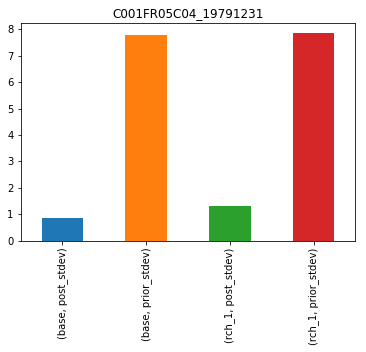

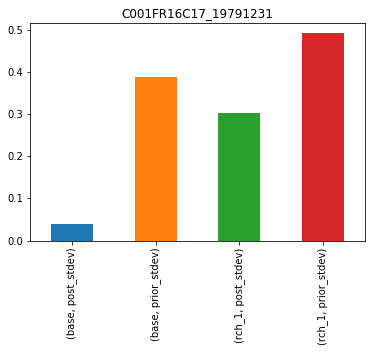

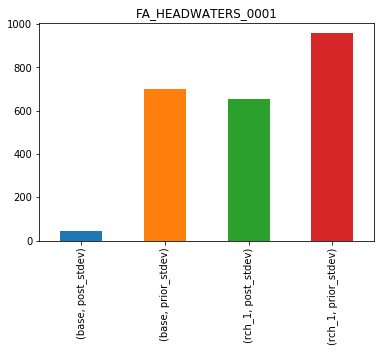

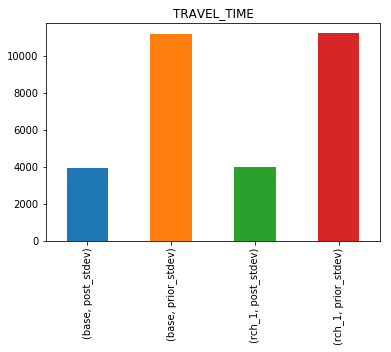

In [58]:
df_foreu_concat.sort_index(axis=1,inplace=True)
for forecast in df_foreu_concat.index:
    df_foreu_concat.loc[forecast,(slice(None),("prior_stdev","post_stdev"))].plot(kind="bar",subplots=True)
    plt.show()

### We see that the posterior for most forecasts is increased because of including future recharge uncertainty.  Intutitively, it makes sense because future recharge directly influences water levels and fluxes in the future.  And since calibration (history-matching) can't tell us anything about future recharge.  This means there is no data we can collect to reduce this source of uncertainty....